# Graph Matching

## Setup

In [1]:
# #Colab
# from google.colab import drive
# drive.mount('/content/drive')
# GNN_PATH = '/content/drive/MyDrive/Colab Notebooks/GNN/'

# #HPC
# #GNN_PATH = './Colab Notebooks/GNN/'
# import os
# if not os.path.exists(GNN_PATH):
#     os.makedirs(GNN_PATH)

In [ ]:
# Install packages
!pip install torch-geometric torch scikit-learn pandas shapely
!pip install git+https://github.com/Thinklab-SJTU/pygmtools.git

# Check pytorch version and make sure you use a GPU Kernel
!python3 -c "import torch; print(torch.__version__)"
!python3 -c "import torch; print(torch.version.cuda)"
!python3 --version
!nvidia-smi

  Cloning https://github.com/Thinklab-SJTU/pygmtools.git to /private/var/folders/zp/9w1jzgvj7bq6mh7s68n3f7dh0000gn/T/pip-req-build-wafc3x6q
  Running command git clone --filter=blob:none --quiet https://github.com/Thinklab-SJTU/pygmtools.git /private/var/folders/zp/9w1jzgvj7bq6mh7s68n3f7dh0000gn/T/pip-req-build-wafc3x6q
  Resolved https://github.com/Thinklab-SJTU/pygmtools.git to commit 80399b1b07722340dd8d6e1bcce2618395fac2db
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
2.2.2
None
Python 3.8.9
zsh:1: command not found: nvidia-smi


# Willow object 

## Willow object Class dataset

In [86]:
# Set backend (required for pygmtools to work)
import pygmtools as pygm
pygm.set_backend('pytorch')  # or 'jittor', 'numpy' if you prefer

# Load the WillowObject dataset
from pygmtools.dataset import WillowObject

size = 1024  # Image size

# Load dataset
dataset = WillowObject(
    sets='train',           # Either 'train' or 'test'
    obj_resize=(size, size)   # Resize objects to a consistent image size
)

dataset.process()

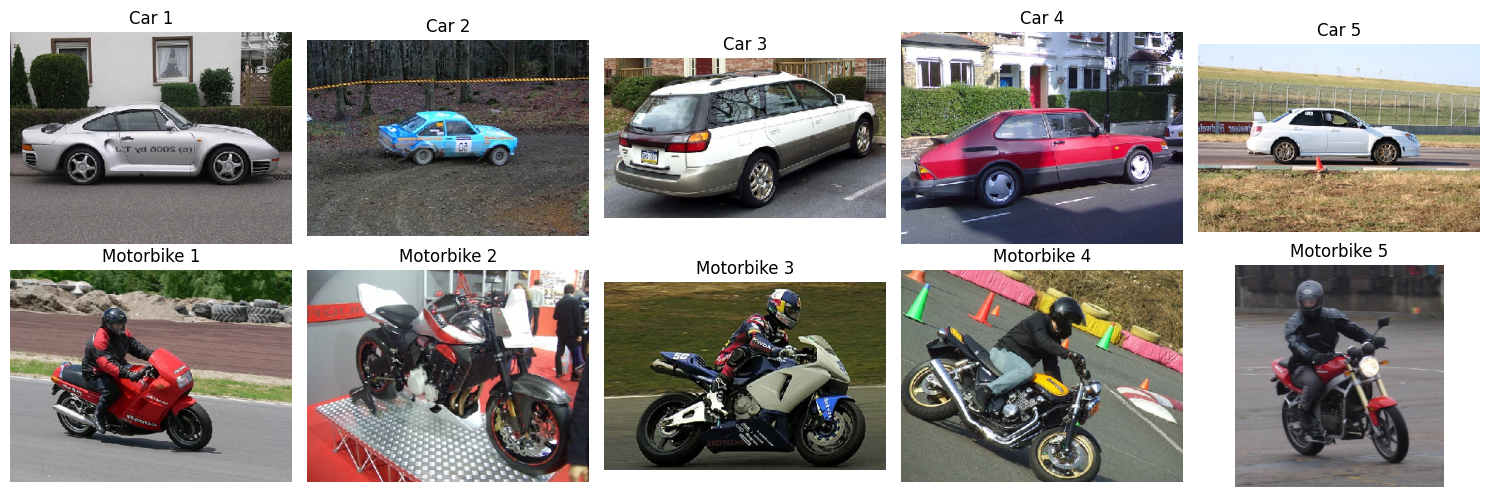

In [87]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Paths
categories = ["Car", "Motorbike"]
base_path = "data/WillowObject/WILLOW-ObjectClass"
dataset_path = os.path.join("data/WillowObject", f"data-({size}, {size})-willow-0.json")

# Number of images
n_images = 5

# Load and visualization
fig, axes = plt.subplots(len(categories), n_images, figsize=(15, 5))
for i, category in enumerate(categories):
    category_path = os.path.join(base_path, category)
    image_files = sorted([f for f in os.listdir(category_path) if f.endswith(".png")])[:n_images]
    for j, img_file in enumerate(image_files):
        img_path = os.path.join(category_path, img_file)
        image = Image.open(img_path)
        axes[i, j].imshow(image)
        axes[i, j].set_title(f"{category} {j+1}")
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()

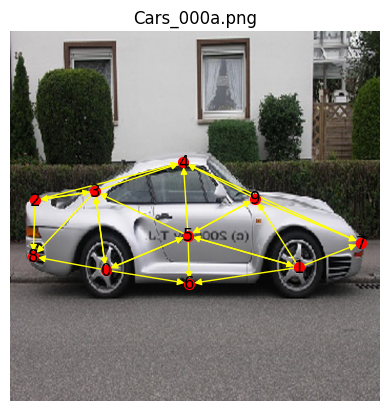

In [88]:
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import Delaunay
import networkx as nx

# Load the JSON file
with open(dataset_path, "r") as f:
    data = json.load(f)

def plot_graph_from_kpts(entry):
    kpts = entry["kpts"]
    points = [(kp["x"], kp["y"]) for kp in kpts]
    tri = Delaunay(points)

    # Create graph
    G = nx.DiGraph()
    for i, (x, y) in enumerate(points):
        G.add_node(i, pos=(x, y))

    for simplex in tri.simplices:
        for i in range(3):
            for j in range(i + 1, 3):
                G.add_edge(simplex[i], simplex[j])

    # Plot image
    img = mpimg.imread(entry["path"])
    img_resized = Image.open(entry["path"]).resize((size, size))
    plt.imshow(img_resized)
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, node_color='red', edge_color='yellow', node_size=50, with_labels=True)
    plt.axis('off')
    plt.title(entry["path"].split('/')[-1])
    plt.show()

# Separate the two lists
car_entries = {k: v for k, v in data.items() if v["cls"] == "Car"}
motorbike_entries = {k: v for k, v in data.items() if v["cls"] == "Motorbike"}

# Show graph for the first image only
for i, (key, entry) in enumerate(car_entries.items()):
    plot_graph_from_kpts(entry)
    break


In [89]:
def graph_from_kpts(entry):
    kpts = entry["kpts"]
    points = [(kp["x"], kp["y"]) for kp in kpts]
    tri = Delaunay(points)

    # Create graph
    G = nx.DiGraph()
    # Add name of the image
    G.graph['name'] = entry["path"].split('/')[-1].replace('.png', '')
    for i, (x, y) in enumerate(points):
        G.add_node(i, pos=(x, y))

    for simplex in tri.simplices:
        for i in range(3):
            for j in range(i + 1, 3):
                G.add_edge(simplex[i], simplex[j])
    return G

def get_graphs(entries):
    graphs = []
    for entry in entries:
        G = graph_from_kpts(entry)
        graphs.append(G)
    return graphs

In [90]:
# Get graphs for car and motorbike entries
car_graphs = get_graphs(car_entries.values())
motorbike_graphs = get_graphs(motorbike_entries.values())

#make dir if not os.path.exists(base_path / graphs):
graphs_path = os.path.join(base_path, "Graphs")
car_path = os.path.join(graphs_path, "car")
motorbike_path = os.path.join(graphs_path, "motorbike")

if not os.path.exists(graphs_path):
    os.makedirs(car_path)
    os.makedirs(motorbike_path)

# Save graphs to disk
import pickle
with open(car_path + "car_graphs.pkl", "wb") as f:
    pickle.dump(car_graphs, f)
with open(motorbike_path + "motorbike_graphs.pkl", "wb") as f:
    pickle.dump(motorbike_graphs, f)
# Load graphs from disk
with open(car_path + "car_graphs.pkl", "rb") as f:
    car_graphs = pickle.load(f)
with open(motorbike_path + "motorbike_graphs.pkl", "rb") as f:
    motorbike_graphs = pickle.load(f)

# Check the number of graphs
print(f"Number of car graphs: {len(car_graphs)}")
print(f"Number of motorbike graphs: {len(motorbike_graphs)}")
# Check the first graph
print(car_graphs[0])
print(car_graphs[0].nodes(data=True))
print(car_graphs[0].edges(data=True))


Number of car graphs: 40
Number of motorbike graphs: 40
DiGraph named 'Cars_000a' with 10 nodes and 25 edges
[(0, {'pos': (264.98395721925135, 660.7629233511587)}), (1, {'pos': (799.5721925133689, 653.2335115864529)}), (2, {'pos': (69.21925133689844, 467.50802139037444)}), (3, {'pos': (234.86631016042784, 442.4099821746882)}), (4, {'pos': (479.57219251336886, 362.09625668449206)}), (5, {'pos': (492.7486631016043, 565.3903743315509)}), (6, {'pos': (496.5133689839571, 698.409982174688)}), (7, {'pos': (972.748663101604, 585.4688057041)}), (8, {'pos': (63.57219251336904, 623.1158645276292)}), (9, {'pos': (679.1016042780747, 462.48841354723714)})]
[(0, 5, {}), (0, 6, {}), (0, 3, {}), (0, 8, {}), (1, 9, {}), (1, 7, {}), (1, 6, {}), (1, 5, {}), (2, 4, {}), (2, 3, {}), (2, 8, {}), (3, 2, {}), (3, 4, {}), (3, 8, {}), (3, 0, {}), (4, 7, {}), (5, 4, {}), (5, 3, {}), (5, 1, {}), (5, 6, {}), (5, 9, {}), (5, 0, {}), (9, 4, {}), (9, 7, {}), (9, 5, {})]


## Graph Matching with pygmtools

### Spectral Matching

Matching accuracy: 0.40
Predicted matching: [(0, 2), (1, 9), (2, 1), (3, 8), (4, 6), (5, 5), (6, 3), (7, 7), (8, 0), (9, 4)]
Ground truth permutation: [9 2 0 6 8 5 3 7 1 4]


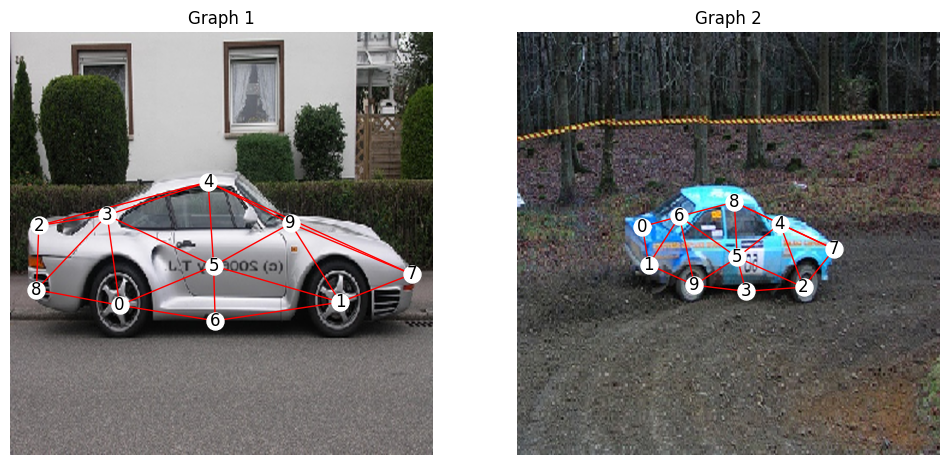

In [91]:
import torch
import pygmtools as pygm
import functools
import numpy as np
from scipy.optimize import linear_sum_assignment

pygm.set_backend('pytorch')

# Nodes with positions
nodes1 = car_graphs[0].nodes(data=True)  # example of a car graph
edges1 = car_graphs[0].edges(data=True)  # example of a car graph

nodes2 = car_graphs[1].nodes(data=True)  # example of a car graph
edges2 = car_graphs[1].edges(data=True)  # example of a car graph

# === STEP 1: Base graph construction (e.g., "cars") ===
n = 10  # number of nodes

# Use the nodes and edges provided for graph 1
nodes1 = [(i, {'pos': data['pos']}) for i, data in nodes1]
edges1 = [(i, j, {}) for i, j, _ in edges1]

# === STEP 2: Apply permutation to graph 2 ===
perm = np.random.permutation(n)  # random permutation of nodes
# Node i of G2 corresponds to node perm[i] of G1
nodes2 = [(i, {'pos': data['pos']}) for i, data in nodes2]
nodes2 = [(perm[i], data) for i, data in nodes2]
nodes2 = sorted(nodes2, key=lambda x: x[0])  # sort by node ID

# Edges also need to be remapped
edges2 = [(perm[i], perm[j], {}) for (i, j, data) in edges2]

# === STEP 3: Ground truth: permutation matrix ===
X_gt = torch.zeros(n, n)
for i in range(n):
    X_gt[i, perm[i]] = 1  # node i of G1 → node perm[i] of G2

# === STEP 4: Convert data for pygmtools ===
def edges_to_adj(edges, n):
    adj = torch.zeros((n, n))
    for i, j, _ in edges:
        adj[i, j] = 1
        adj[j, i] = 1
    return adj

A1 = edges_to_adj(edges1, n).unsqueeze(0)
A2 = edges_to_adj(edges2, n).unsqueeze(0)

# Convert to sparse and build affinity matrix
conn1, edge1, ne1 = pygm.utils.dense_to_sparse(A1)
conn2, edge2, ne2 = pygm.utils.dense_to_sparse(A2)

n_tensor = torch.tensor([n])

gaussian_aff = functools.partial(pygm.utils.gaussian_aff_fn, sigma=1.)

K = pygm.utils.build_aff_mat(
    None, edge1, conn1,
    None, edge2, conn2,
    n_tensor, None, n_tensor, None,
    edge_aff_fn=gaussian_aff
)

# === STEP 5: Solve matching with SM ===
S = pygm.sm(K, n1=n_tensor, n2=n_tensor)
S = S.view(n, n).detach().numpy()

# Final matching
row_ind, col_ind = linear_sum_assignment(-S)
X_pred = np.zeros_like(S)
X_pred[row_ind, col_ind] = 1

# === STEP 6: Accuracy ===
acc = (torch.tensor(X_pred) * X_gt).sum() / X_gt.sum()
print(f"Matching accuracy: {acc.item():.2f}")
print("Predicted matching:", list(zip(row_ind, col_ind)))
print("Ground truth permutation:", perm)

# === STEP 7: Visualization ===
# Visualize in a single image the two cars and the two graphs with connections between matched nodes
def plot_graphs(nodes1, edges1, nodes2, edges2, entry1, entry2):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Graph 1 with image
    img1 = mpimg.imread(entry1["path"])
    img1_resized = Image.open(entry1["path"]).resize((size, size))
    axs[0].imshow(img1_resized)
    G1 = nx.Graph()
    G1.add_nodes_from(nodes1)
    G1.add_edges_from(edges1)
    pos1 = {i: data['pos'] for i, data in nodes1}
    nx.draw(G1, pos=pos1, ax=axs[0], node_color='white', edge_color='red', node_size=150, with_labels=True)
    axs[0].set_title("Graph 1")
    axs[0].axis('off')

    # Graph 2 with image
    img2 = mpimg.imread(entry2["path"])
    img2_resized = Image.open(entry2["path"]).resize((size, size))
    axs[1].imshow(img2_resized)
    G2 = nx.Graph()
    G2.add_nodes_from(nodes2)
    G2.add_edges_from(edges2)
    pos2 = {i: data['pos'] for i, data in nodes2}
    nx.draw(G2, pos=pos2, ax=axs[1], node_color='white', edge_color='red', node_size=150, with_labels=True)
    axs[1].set_title("Graph 2")
    axs[1].axis('off')

    plt.show()

# Example usage
plot_graphs(nodes1, edges1, nodes2, edges2, car_entries["Cars_000a"], car_entries["Cars_001b"])


### IPCA Model

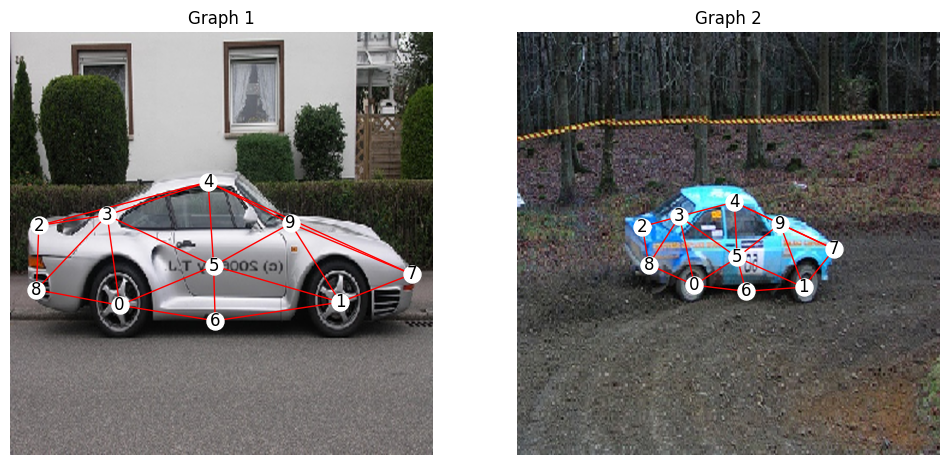

Graph 1 node features shape: torch.Size([10, 2])
Graph 2 node features shape: torch.Size([10, 2])
Graph 1 node features shape: torch.Size([10, 1024])
Graph 2 node features shape: torch.Size([10, 1024])
Graph Matching Matrix:
     0    1    2    3    4             5    6    7    8    9
0  0.0  0.0  0.0  0.0  0.0  1.111111e-01  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0  1.111111e-01  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0  1.111111e-01  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0  1.111111e-01  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0  1.111111e-01  0.0  0.0  0.0  0.0
5  0.0  0.0  0.0  0.0  0.0  1.111111e-01  0.0  0.0  0.0  0.0
6  0.0  0.0  0.0  0.0  0.0  1.111111e-01  0.0  0.0  0.0  0.0
7  0.0  0.0  0.0  0.0  0.0  1.111111e-01  0.0  0.0  0.0  0.0
8  1.0  1.0  1.0  1.0  1.0  6.580278e-19  1.0  1.0  1.0  1.0
9  0.0  0.0  0.0  0.0  0.0  1.111111e-01  0.0  0.0  0.0  0.0
Hungarian:
     0    1    2    3    4    5    6    7    8    9
0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0

In [92]:
import torch
import numpy as np
import pygmtools as pygm
import torch.nn.functional as F
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
import pygmtools as pygm
import torch

pygm.BACKEND = 'pytorch'

# Load graph data
graph1 = car_graphs[0]
graph2 = car_graphs[1]

nodes1 = graph1.nodes(data=True)
nodes2 = graph2.nodes(data=True)
edges1 = graph1.edges(data=True)
edges2 = graph2.edges(data=True)

plot_graphs(nodes1, edges1, nodes2, edges2, car_entries[graph1.graph['name']], car_entries[graph2.graph['name']])

adj1 = nx.adjacency_matrix(graph1).todense()
adj2 = nx.adjacency_matrix(graph2).todense()

# Extract node features (e.g., positions) from the graph nodes
g1_node_feat = torch.tensor([data['pos'] for _, data in graph1.nodes(data=True)], dtype=torch.float32)
g2_node_feat = torch.tensor([data['pos'] for _, data in graph2.nodes(data=True)], dtype=torch.float32)
adj1 = torch.tensor(adj1, dtype=torch.float32)
adj2 = torch.tensor(adj2, dtype=torch.float32)

print(f"Graph 1 node features shape: {g1_node_feat.shape}")
print(f"Graph 2 node features shape: {g2_node_feat.shape}")

desired_dim = 1024

# Padding with 0s
g1_node_feat_padded = F.pad(g1_node_feat, (0, desired_dim - g1_node_feat.shape[1]))
g2_node_feat_padded = F.pad(g2_node_feat, (0, desired_dim - g2_node_feat.shape[1]))

print(f"Graph 1 node features shape: {g1_node_feat_padded.shape}")
print(f"Graph 2 node features shape: {g2_node_feat_padded.shape}")

# Apply IPCA-GM model for graph matching
match_result = pygm.ipca_gm(
    A1=adj1.to(torch.float32), A2=adj2.to(torch.float32),
    feat1=g1_node_feat_padded, feat2=g2_node_feat_padded,
    pretrain='willow'
)

# Convert to a DataFrame for better readability
df_match = pd.DataFrame(match_result.detach().numpy())

matched = pygm.hungarian(match_result)
df_matched = pd.DataFrame(matched)

# Display the DataFrame in the terminal
# Calculate accuracy
identity_matrix = torch.eye(n)  # Ground truth is the identity matrix
accuracy = (matched * identity_matrix).sum() / identity_matrix.sum()

print("Graph Matching Matrix:")
print(df_match.to_string(index=True, header=True))
print("Hungarian:")
print(df_matched.to_string(index=True, header=True))
print(f"Matching Accuracy: {accuracy.item():.2f}")


The model expects an input of dimensions [10, 1024], which corresponds to features extracted from CNN layers applied to the image. Since we do not have access to these features, the results obtained are suboptimal.

## Graph Matching with GNN from scratch 

In [5]:
# Set Seed for reproducibility
import random
import numpy as np
import torch

seed = 42

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    os.environ['PYTHONHASHSEED'] = str(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed once at the beginning
set_seed(seed)

# For reproducible DataLoader shuffle
g = torch.Generator()
g.manual_seed(seed)

### Dataset split

Functions to convert DiGraphs to pyg data and viceversa, pyg data are more compatible with GNN models

In [ ]:
import torcah
import networkx as nx
from torch_geometric.data import Data
from typing import List, Tuple

def pyg_data_to_nx_digraph(data: Data) -> nx.DiGraph:
    """
    Convert a PyTorch Geometric Data object back to a NetworkX DiGraph,
    restoring original node IDs using data.node_names.
    """
    assert hasattr(data, 'node_names'), "Data object must contain 'node_names' to restore original node IDs."

    G = nx.DiGraph()
    node_ids = data.node_names

    # Aggiungi nodi con pos
    for i, node_id in enumerate(node_ids):
        G.add_node(node_id, pos=data.x[i].tolist())

    # Aggiungi archi mappati indietro a ID originali
    edge_index = data.edge_index
    for u_idx, v_idx in edge_index.t().tolist():
        u = node_ids[u_idx]
        v = node_ids[v_idx]
        G.add_edge(u, v)

    # Aggiungi nome del grafo, se esiste
    if hasattr(data, 'name') and data.name is not None:
        G.graph['name'] = data.name

    return G

def nx_to_pyg_data_preserve_order(graph: nx.DiGraph) -> Data:
    """
    Convert a NetworkX DiGraph to a PyTorch Geometric Data object,
    preserving the insertion order of nodes.
    """
    node_ids = list(graph.nodes())  # preserve insertion order
    id_map = {node_id: i for i, node_id in enumerate(node_ids)}

    # Build node features tensor
    x = torch.stack([
        torch.tensor(graph.nodes[n]['pos'], dtype=torch.float32)
        for n in node_ids
    ])

    # Remap edges using the insertion-order mapping
    edge_index = torch.tensor([
        [id_map[u], id_map[v]] for u, v in graph.edges()
    ], dtype=torch.long).t().contiguous() if graph.edges else torch.empty((2, 0), dtype=torch.long)

    # Optionally, store the original node order as a list of IDs
    data = Data(x=x, edge_index=edge_index)
    data.node_names = node_ids  # so you can always recover original labels
    data.name = graph.graph.get("name")

    return data

Generate G1,G2,GT dataset

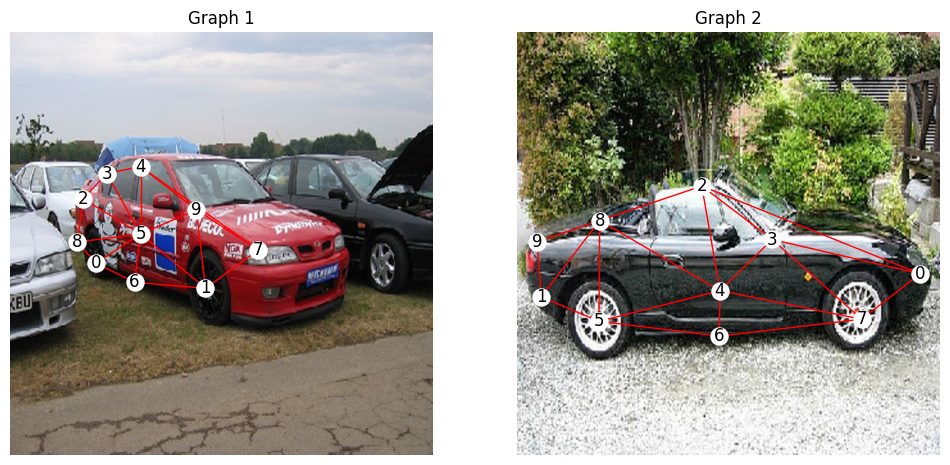

G1 nodes: [(0, {'pos': [207.9085693359375, 558.8114013671875]}), (1, {'pos': [473.0514221191406, 619.7637939453125]}), (2, {'pos': [176.82286071777344, 402.7733459472656]}), (3, {'pos': [233.50857543945312, 341.8209533691406]}), (4, {'pos': [315.7942810058594, 324.7542724609375]}), (5, {'pos': [315.7942810058594, 488.1066589355469]}), (6, {'pos': [301.16571044921875, 605.13525390625]}), (7, {'pos': [601.0514526367188, 527.1162109375]}), (8, {'pos': [162.1942901611328, 507.6114196777344]}), (9, {'pos': [451.10858154296875, 429.5923767089844]})]
G2 permuted nodes: [(0, {'pos': [975.3367309570312, 584.472900390625]}), (1, {'pos': [57.716617584228516, 640.4393920898438]}), (2, {'pos': [446.4872741699219, 371.9928894042969]}), (3, {'pos': [617.075439453125, 501.39410400390625]}), (4, {'pos': [490.5580749511719, 625.432861328125]}), (5, {'pos': [197.39151000976562, 699.6728515625]}), (6, {'pos': [488.6419372558594, 735.5128784179688]}), (7, {'pos': [833.5437622070312, 694.5528564453125]}), (

In [102]:
def generate_matching_pairs_as_data(
    g1: nx.DiGraph,
    graph_list: List[nx.DiGraph],
    g1_idx: int,
    pairs_list: List[Tuple[Data, Data, torch.Tensor]]
) -> None:
    """
    Generate matching pairs as torch_geometric Data objects with a permutation matrix.

    Args:
        g1: Reference graph as networkx.DiGraph
        graph_list: List of all networkx.DiGraphs
        g1_idx: Index of g1 in graph_list (to skip self-pairs)
        pairs_list: List to store (Data1, Data2_permuted, P) tuples
    """

    assert g1.number_of_nodes() == 10, f"Graph {g1_idx} has {g1.number_of_nodes()} nodes!"

    pyg_g1 = nx_to_pyg_data_preserve_order(g1)

    for j, g2_orig in enumerate(graph_list):
        if j == g1_idx:
            continue

        assert g2_orig.number_of_nodes() == pyg_g1.num_nodes, f"Mismatch nodes in g1 ({g1_idx}) and g2 ({j})"

        num_nodes = g2_orig.number_of_nodes()
        nodes_g2 = list(sorted(g2_orig.nodes()))
        assert nodes_g2 == list(range(num_nodes)), "Nodes must be consecutively indexed"

        # Create a random permutation
        perm = torch.randperm(num_nodes)

        # Build the permutation matrix: P[i, j] = 1 if node i in G1 ↔ node j in G2_permuted
        P = torch.zeros((num_nodes, num_nodes), dtype=torch.float32)
        for i in range(num_nodes):
            P[i, perm[i]] = 1.0

        # Create permuted G2
        g2_permuted = nx.DiGraph()
        g2_permuted.graph['name'] = g2_orig.graph['name']  # Copy the name of the graph

        for new_idx in range(num_nodes):
            old_idx = perm[new_idx].item()
            g2_permuted.add_node(new_idx, pos=g2_orig.nodes[old_idx]['pos'])

        for u, v, data in g2_orig.edges(data=True):
            new_u = (perm == u).nonzero(as_tuple=True)[0].item()
            new_v = (perm == v).nonzero(as_tuple=True)[0].item()
            g2_permuted.add_edge(new_u, new_v, **data)

        pyg_g2 = nx_to_pyg_data_preserve_order(g2_permuted)
        pairs_list.append((pyg_g1, pyg_g2, P.T))  # P.T so that P[i, j] = G1[i] ↔ G2[j]

# Split the data into 60% train, 20% validation, and 20% test
def split_graphs(graphs):
    train, temp = train_test_split(graphs, test_size=0.4, random_state=seed)
    val, test = train_test_split(temp, test_size=0.5, random_state=seed)
    return train, val, test

cars_train, cars_val, cars_test = split_graphs(car_graphs)

train_list = []
for i, g1 in enumerate(cars_train):
    generate_matching_pairs_as_data(g1, cars_train, i, train_list)

val_list = []
for i, g1 in enumerate(cars_val):
    generate_matching_pairs_as_data(g1, cars_val, i, val_list)

test_list = []
for i, g1 in enumerate(cars_test):
    generate_matching_pairs_as_data(g1, cars_test, i, test_list)

# Visualize the two graphs
g1_out, g2_perm, gt_perm = test_list[0]

g1_out = pyg_data_to_nx_digraph(g1_out)
g2_perm = pyg_data_to_nx_digraph(g2_perm)

plot_graphs(
    nodes1=g1_out.nodes(data=True),
    edges1=g1_out.edges(data=True),
    nodes2=g2_perm.nodes(data=True),
    edges2=g2_perm.edges(data=True),
    entry1=data[g1_out.name],
    entry2=data[g2_perm.name]
)

print("G1 nodes:", g1_out.nodes(data=True))
print("G2 permuted nodes:", g2_perm.nodes(data=True))
print("Ground truth permutation:\n", gt_perm)

In [104]:
from torch.utils.data import Dataset

class GraphMatchingDataset(Dataset):
    def __init__(self, pairs):  # lista di (Data, Data, P)
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.pairs[idx]  # data1, data2, P
    
from torch_geometric.data import Batch

def collate_pyg_matching(batch):
    data1_list, data2_list, perm_list = zip(*batch)
    batch1 = Batch.from_data_list(data1_list)
    batch2 = Batch.from_data_list(data2_list)
    perm_tensor = torch.stack(perm_list)  # shape [B, N, N]
    return batch1, batch2, perm_tensor

In [105]:
# Define hyperparameters
in_dim = 2  # Dimension of node features
hidden_dim = 64  # Hidden dimension for GNN
out_dim = 32  # Output dimension for GNN
num_epochs = 20
learning_rate = 0.001
batch_size = 5

from torch.utils.data import DataLoader

train_dataset = GraphMatchingDataset(train_list)
val_dataset = GraphMatchingDataset(val_list)
test_dataset = GraphMatchingDataset(test_list)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_pyg_matching, generator=g)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)

### Model

In [107]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class MatchingModel_2GCN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.gnn = nn.ModuleList([
            GCNConv(in_dim, hidden_dim),
            GCNConv(hidden_dim, out_dim)
        ])

    def encode(self, x, edge_index):
        for i, conv in enumerate(self.gnn):
            x = conv(x, edge_index)
            if i < len(self.gnn) - 1:
                x = F.relu(x)
        return x  # shape [num_nodes, out_dim]

    def forward(self, x1, edge_index1, x2, edge_index2):
        """
        Args:
            x1, x2: node features of graph 1 and 2 (shapes [N, in_dim])
            edge_index1, edge_index2: edge indices of graph 1 and 2 ([2, num_edges])

        Returns:
            scores: similarity matrix [N, N], where scores[i, j] = node i in G1 vs node j in G2
        """
        h1 = self.encode(x1, edge_index1)  # [N, D]
        h2 = self.encode(x2, edge_index2)  # [N, D]
        scores = torch.matmul(h1, h2.T)    # [N, N]
        return scores

### Training

In [ ]:
import torch.nn.functional as F

def train_epoch(model, loader, optimizer):
    """
    Train the model for one epoch.

    Args:
        model: The graph matching model to train.
        loader: DataLoader providing batches of graph pairs and ground truth permutation matrices.
        optimizer: Optimizer for updating model parameters.

    Returns:
        The average loss over all batches.
    """
    model.train()  # Set the model to training mode
    total_loss = 0  # Initialize total loss

    for batch1, batch2, P in loader:  # Iterate over batches
        optimizer.zero_grad()  # Reset gradients

        # Extract node features and edge indices for both graphs
        x1, edge1, batch_idx1 = batch1.x, batch1.edge_index, batch1.batch
        x2, edge2, batch_idx2 = batch2.x, batch2.edge_index, batch2.batch

        # Encode node features using the model
        h1 = model.encode(x1, edge1)
        h2 = model.encode(x2, edge2)

        loss = 0.0  # Initialize batch loss
        B = P.size(0)  # Number of graphs in the batch
        N = P.size(1)  # Number of nodes in each graph

        for i in range(B):  # Iterate over graphs in the batch
            # Select node embeddings for the current graph pair
            h1_i = h1[batch_idx1 == i]  # Node embeddings for graph 1
            h2_i = h2[batch_idx2 == i]  # Node embeddings for graph 2

            # Compute similarity matrix between nodes of the two graphs
            sim = torch.matmul(h1_i, h2_i.T)  # Shape: [N, N]

            # Compute binary cross-entropy loss between similarity and ground truth permutation
            loss += F.binary_cross_entropy_with_logits(sim, P[i])

        loss /= B  # Average loss over the batch
        loss.backward()  # Backpropagate gradients
        optimizer.step()  # Update model parameters
        total_loss += loss.item()  # Accumulate total loss

    return total_loss / len(loader)  # Return average loss over all batches

def evaluate(model, loader):
    """
    Evaluate the model on a validation or test set.

    Args:
        model: The graph matching model to evaluate.
        loader: DataLoader providing batches of graph pairs and ground truth permutation matrices.

    Returns:
        The accuracy of the model.
    """
    model.eval()  # Set the model to evaluation mode
    correct = 0  # Initialize correct predictions counter
    total = 0  # Initialize total predictions counter

    with torch.no_grad():  # Disable gradient computation
        for batch1, batch2, P in loader:  # Iterate over batches
            # Extract node features and edge indices for both graphs
            x1, edge1, batch_idx1 = batch1.x, batch1.edge_index, batch1.batch
            x2, edge2, batch_idx2 = batch2.x, batch2.edge_index, batch2.batch

            # Encode node features using the model
            h1 = model.encode(x1, edge1)
            h2 = model.encode(x2, edge2)

            B, N = P.size(0), P.size(1)  # Number of graphs and nodes

            for i in range(B):  # Iterate over graphs in the batch
                # Select node embeddings for the current graph pair
                h1_i = h1[batch_idx1 == i]
                h2_i = h2[batch_idx2 == i]

                # Compute similarity matrix between nodes of the two graphs
                sim = torch.matmul(h1_i, h2_i.T)

                # Predict node matches by selecting the maximum similarity
                pred = sim.argmax(dim=1)  # Predicted matches
                target = P[i].argmax(dim=1)  # Ground truth matches

                # Count correct predictions
                correct += (pred == target).sum().item()
                total += N  # Update total predictions

    return correct / total  # Return accuracy as the ratio of correct predictions


In [ ]:
model = MatchingModel_2GCN(in_dim=in_dim, hidden_dim=hidden_dim, out_dim=out_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    loss = train_epoch(model, train_loader, optimizer)
    acc = evaluate(model, val_loader)
    print(f"[Epoch {epoch}] Loss: {loss:.4f} | Val Acc: {acc:.4f}")


[Epoch 0] Loss: 85168.2820 | Val Acc: 0.1714
[Epoch 1] Loss: 1276.9560 | Val Acc: 0.1571
[Epoch 2] Loss: 388.2910 | Val Acc: 0.1500
[Epoch 3] Loss: 182.1495 | Val Acc: 0.1446
[Epoch 4] Loss: 110.4766 | Val Acc: 0.1393
[Epoch 5] Loss: 75.6899 | Val Acc: 0.1286
[Epoch 6] Loss: 57.7993 | Val Acc: 0.1286
[Epoch 7] Loss: 46.5013 | Val Acc: 0.1268
[Epoch 8] Loss: 40.9226 | Val Acc: 0.1268
[Epoch 9] Loss: 33.3705 | Val Acc: 0.1250
[Epoch 10] Loss: 27.6108 | Val Acc: 0.1268
[Epoch 11] Loss: 23.9657 | Val Acc: 0.1268
[Epoch 12] Loss: 21.0321 | Val Acc: 0.1179
[Epoch 13] Loss: 18.1895 | Val Acc: 0.1232
[Epoch 14] Loss: 15.9816 | Val Acc: 0.1196
[Epoch 15] Loss: 13.9789 | Val Acc: 0.1179
[Epoch 16] Loss: 11.9520 | Val Acc: 0.1179
[Epoch 17] Loss: 11.2008 | Val Acc: 0.1125
[Epoch 18] Loss: 9.8192 | Val Acc: 0.1125
[Epoch 19] Loss: 9.3869 | Val Acc: 0.1196


In [6]:
evaluate(model, test_loader)
print(f"Test Acc: {acc:.4f}")

# use the model to predict the matching on a test graph
g1_out, g2_perm, gt_perm = test_list[0]  



NameError: name 'evaluate' is not defined

# MSD dataset for SLAM

## Graph Matching with GNN from scratch 

In [113]:
# Set Seed for reproducibility
import random
import numpy as np
import torch
import os

seed = 42

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    os.environ['PYTHONHASHSEED'] = str(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed once at the beginning
set_seed(seed)

# For reproducible DataLoader shuffle
g = torch.Generator()
g.manual_seed(seed)

### Dataset split

In [114]:
import pickle
import networkx as nx
from pathlib import Path
import matplotlib.pyplot as plt
from shapely.geometry import Polygon


def deserialize_MSD_dataset():
    dataset_dir = Path("data")

    # Load dimensions
    dimensions_file = dataset_dir / "dimensions.pickle"
    if not dimensions_file.exists():
        raise FileNotFoundError(f"Dimensions file not found at {dimensions_file}")
    with open(dimensions_file, 'rb') as f:
        dimensions = pickle.load(f)

    # Clear existing graphs
    original = []
    noise = []

    # Deserialize original graphs
    original_dir = dataset_dir / "original"
    for file in sorted(original_dir.glob("*.pt")):
        graph = nx.DiGraph()
        with open(str(file), "rb") as f:
            graph = pickle.load(f)
            graph.graph['name'] = file.stem
        original.append(graph)

    # Deserialize noise graphs
    noise_dir = dataset_dir / "noise"
    for file in sorted(noise_dir.glob("*.pt")):
        graph = nx.DiGraph()
        with open(str(file), "rb") as f:
            graph = pickle.load(f)
            graph.graph['name'] = file.stem
        noise.append(graph)

    return original, noise, dimensions

original_graphs, noise_graphs, dimensions = deserialize_MSD_dataset()

# Check the number of graphs
print(f"Number of original graphs: {len(original_graphs)}")
print(f"Number of noise graphs: {len(noise_graphs)}")
assert len(original_graphs) == len(dimensions), "Number of original and dimensions must be the same"

# print the first graph
print(original_graphs[0].graph['name'])
print(original_graphs[0].nodes(data=True))
print(original_graphs[0].edges(data=True))

print(noise_graphs[0].graph['name'])
print(noise_graphs[0].nodes(data=True))
print(noise_graphs[0].edges(data=True))



Number of original graphs: 67
Number of noise graphs: 496
0
[('1588_3c3b1d6ca8b4b9092480b8c75f9eaa81_Bathroom_0_centroid', {'polygon': [(-2.733784407826521, 4.079807440832154), (-1.705298209060592, 5.305509563145014), (-1.1780751324833911, 4.863116874040932), (-1.282147811769141, 4.739087884611235), (0.0038369733703361, 3.6600185257011066), (-0.9205765461098432, 2.5583453928179463), (-2.733784407826521, 4.079807440832154)], 'center': [-1.369054778042023, 3.9064409996318883, 1.3], 'normal': [0, 0, 1], 'type': 'room', 'category': 7, 'category_letter': 'Bathroom'}), ('1588_3c3b1d6ca8b4b9092480b8c75f9eaa81_Bathroom_0_ws_0', {'geom': [array([-2.73378441,  4.07980744]), array([-1.70529821,  5.30550956])], 'polygon': [(-2.733784407826521, 4.079807440832154), (-1.705298209060592, 5.305509563145014), (-1.705298209060592, 5.315509563145014), (-2.733784407826521, 4.089807440832153), (-2.733784407826521, 4.079807440832154)], 'center': [-2.2195413084435565, 4.692658501988584, 1.3], 'normal': [0.766

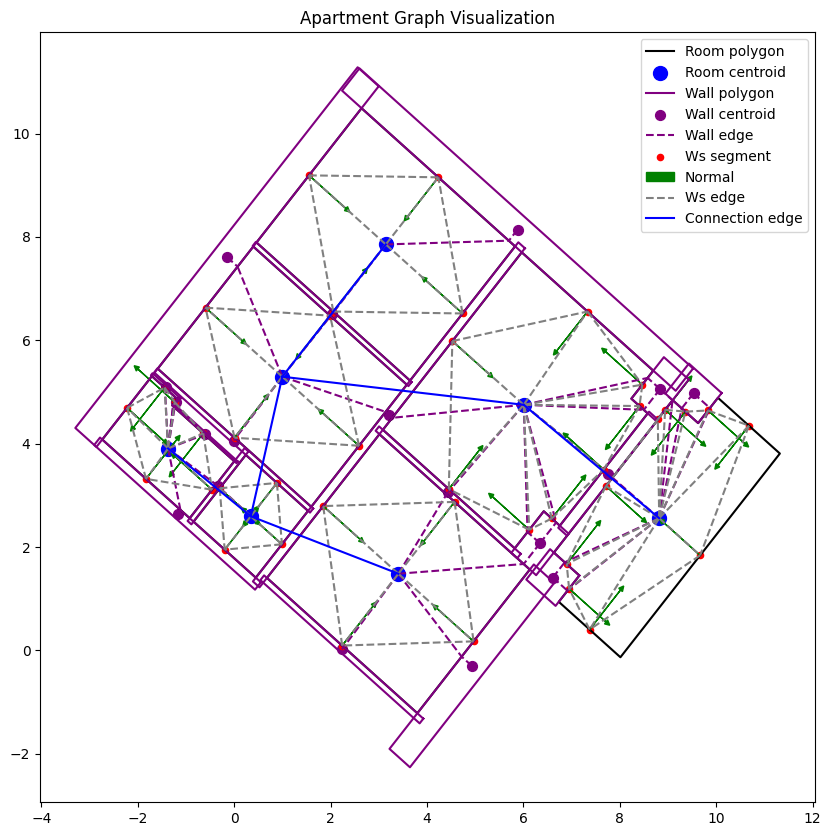

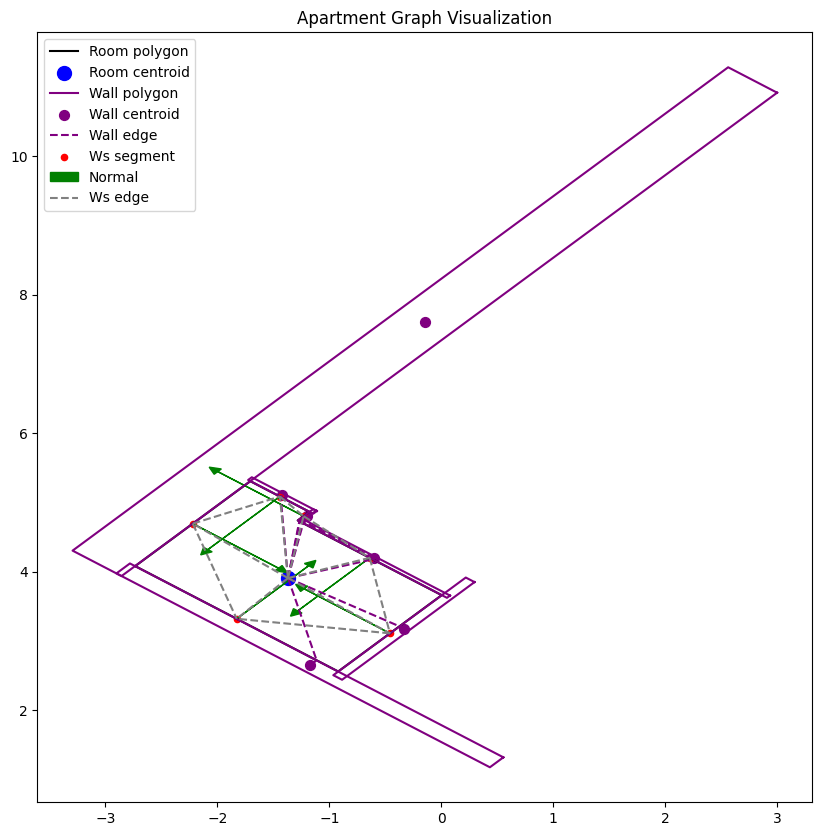

In [115]:
def plot_a_graph(graphs_list, viz_rooms=True, viz_ws=True, viz_openings=False, viz_room_connection=True, viz_normals=False, viz_room_normals=False, viz_walls=True):
    """
    Visualizes geometries, wall segments, and graph edges for multiple apartments in 2D.

    Parameters:
    graphs_list (list of networkx.Graph): List of graphs with nodes ('type', 'center', 'normal') and edges for the apartments.
    viz_normals (bool): If True, plots wall segment normals.
    viz_rooms (bool): If True, displays room polygons.
    viz_ws (bool): If True, displays wall segments.
    viz_openings (bool): If True, displays openings (doors and windows).
    viz_wall_edges (bool): If True, displays edges between wall segments.
    viz_connection_edges (bool): If True, displays edges connecting rooms via openings.
    viz_walls (bool): If True, displays wall nodes and their edges.
    """
    _, ax = plt.subplots(1, 1, figsize=(10, 10))
    legend_added = False  # Flag to ensure the legend is added only once
    normal_added = False  # Flag to ensure the "Normal" label is added only once

    for graphs in graphs_list:
        # Visualize room polygons
        if viz_rooms:
            room_nodes = [n for n, d in graphs.nodes(data=True) if d['type'] == 'room']
            for idx, room_node in enumerate(room_nodes):
                room_data = graphs.nodes[room_node]
                # Plot the polygon
                room_polygon = Polygon(room_data['polygon'])
                x, y = room_polygon.exterior.xy
                ax.plot(x, y, color='black', label='Room polygon' if not legend_added and idx == 0 else "")
                # Draw room centroids
                ax.scatter(room_data['center'][0], room_data['center'][1], color='blue', s=100, label='Room centroid' if not legend_added and idx == 0 else "")

        # Visualize wall nodes and edges
        if viz_walls:
            wall_nodes = [n for n, d in graphs.nodes(data=True) if d['type'] == 'wall']
            for idx, wn in enumerate(wall_nodes):
                wall_data = graphs.nodes[wn]
                # Plot the polygon of the wall
                wall_polygon = Polygon(wall_data['polygon'])
                x, y = wall_polygon.exterior.xy
                ax.plot(x, y, color='purple', linestyle='-', label='Wall polygon' if not legend_added and idx == 0 else "")
                ax.scatter(wall_data['center'][0], wall_data['center'][1], color='purple', s=50, label='Wall centroid' if not legend_added and idx == 0 else "")

            if viz_normals:
                wall_ws = [n for n, d in graphs.nodes(data=True) if d['type'] == 'wall_ws']
                for idx, wn in enumerate(wall_ws):
                    ws_data = graphs.nodes[wn]
                    ax.scatter(ws_data['center'][0], ws_data['center'][1], color='purple', s=20, label='Wall ws' if not legend_added and idx == 0 else "")
                    ax.arrow(ws_data['center'][0], ws_data['center'][1],
                             ws_data['normal'][0], ws_data['normal'][1],
                             head_width=0.1, head_length=0.1, fc='green', ec='green', label='Normal' if not normal_added else "")
                    normal_added = True

            wall_edges = [(u, v) for u, v, d in graphs.edges(data=True) if 'wall' in u or 'wall' in v]
            for idx, edge in enumerate(wall_edges):
                start_node = graphs.nodes[edge[0]]
                end_node = graphs.nodes[edge[1]]
                ax.plot([start_node['center'][0], end_node['center'][0]],
                        [start_node['center'][1], end_node['center'][1]],
                        color='purple', linestyle='--', label='Wall edge' if not legend_added and idx == 0 else "")

        # Visualize openings
        if viz_openings:
            opening_nodes = [n for n, d in graphs.nodes(data=True) if 'door' in d['type'] or 'window' in d['type']]
            for idx, on in enumerate(opening_nodes):
                opening_data = graphs.nodes[on]
                opening_polygon = Polygon(opening_data['polygon'])
                x, y = opening_polygon.exterior.xy
                ax.plot(x, y, color='orange', label='Opening polygon' if not legend_added and idx == 0 else "")
                # Draw opening centroids
                ax.scatter(opening_data['center'][0], opening_data['center'][1], color='orange', s=10, label='Opening centroid' if not legend_added and idx == 0 else "")

            if viz_normals:
                opening_ws = [n for n, d in graphs.nodes(data=True) if d['type'] == 'door_ws' or d['type'] == 'window_ws']
                for idx, wn in enumerate(opening_ws):
                    ws_data = graphs.nodes[wn]
                    ax.scatter(ws_data['center'][0], ws_data['center'][1], color='orange', s=10, label='Opening ws' if not legend_added and idx == 0 else "")
                    ax.arrow(ws_data['center'][0], ws_data['center'][1],
                             ws_data['normal'][0], ws_data['normal'][1],
                             head_width=0.1, head_length=0.1, fc='green', ec='green', label='Normal' if not normal_added else "")
                    normal_added = True

            # Draw opening edges
            open_edges = [(u, v) for u, v, d in graphs.edges(data=True) if 'door' in u or 'window' in v or 'door' in v or 'window' in u]
            for idx, edge in enumerate(open_edges):
                start_node = graphs.nodes[edge[0]]
                end_node = graphs.nodes[edge[1]]
                ax.plot([start_node['center'][0], end_node['center'][0]],
                        [start_node['center'][1], end_node['center'][1]],
                        color='orange', linestyle='--', label='Opening edge' if not legend_added and idx == 0 else "")

        # Visualize ws room
        if viz_ws:
            ws_nodes = [n for n, d in graphs.nodes(data=True) if d['type'] == 'ws']
            for idx, wn in enumerate(ws_nodes):
                ws_data = graphs.nodes[wn]
                ax.scatter(ws_data['center'][0], ws_data['center'][1], color='red', s=20, label='Ws segment' if not legend_added and idx == 0 else "")
                if viz_room_normals:
                    ax.arrow(ws_data['center'][0], ws_data['center'][1],
                             ws_data['normal'][0], ws_data['normal'][1],
                             head_width=0.1, head_length=0.1, fc='green', ec='green', label='Normal' if not normal_added else "")
                    normal_added = True

            ws_edges = [(u, v) for u, v, d in graphs.edges(data=True) if 'ws_same_room' in d['type'] or 'ws_belongs_room' in d['type']]
            for idx, edge in enumerate(ws_edges):
                start_node = graphs.nodes[edge[0]]
                end_node = graphs.nodes[edge[1]]
                ax.plot([start_node['center'][0], end_node['center'][0]],
                    [start_node['center'][1], end_node['center'][1]],
                    color='gray', linestyle='--', label='Ws edge' if not legend_added and idx == 0 else "")

        # Visualize connection edges
        if viz_room_connection:
            connection_edges = [(u, v) for u, v, d in graphs.edges(data=True) if 'connected' in d['type']]
            for idx, edge in enumerate(connection_edges):
                start_node = graphs.nodes[edge[0]]
                end_node = graphs.nodes[edge[1]]
                ax.plot([start_node['center'][0], end_node['center'][0]],
                        [start_node['center'][1], end_node['center'][1]],
                        color='blue', linestyle='-', label='Connection edge' if not legend_added and idx == 0 else "")

        legend_added = True  # Set the flag to True after processing the first graph

    plt.title("Apartment Graph Visualization")
    plt.legend()
    plt.show()

plot_a_graph([original_graphs[0]], viz_rooms=True, viz_ws=True, viz_openings=False, viz_room_connection=True, viz_normals=False, viz_room_normals=True, viz_walls=True)
plot_a_graph([noise_graphs[0]], viz_rooms=True, viz_ws=True, viz_openings=False, viz_room_connection=True, viz_normals=False, viz_room_normals=True, viz_walls=True)


57
127
186
52
98


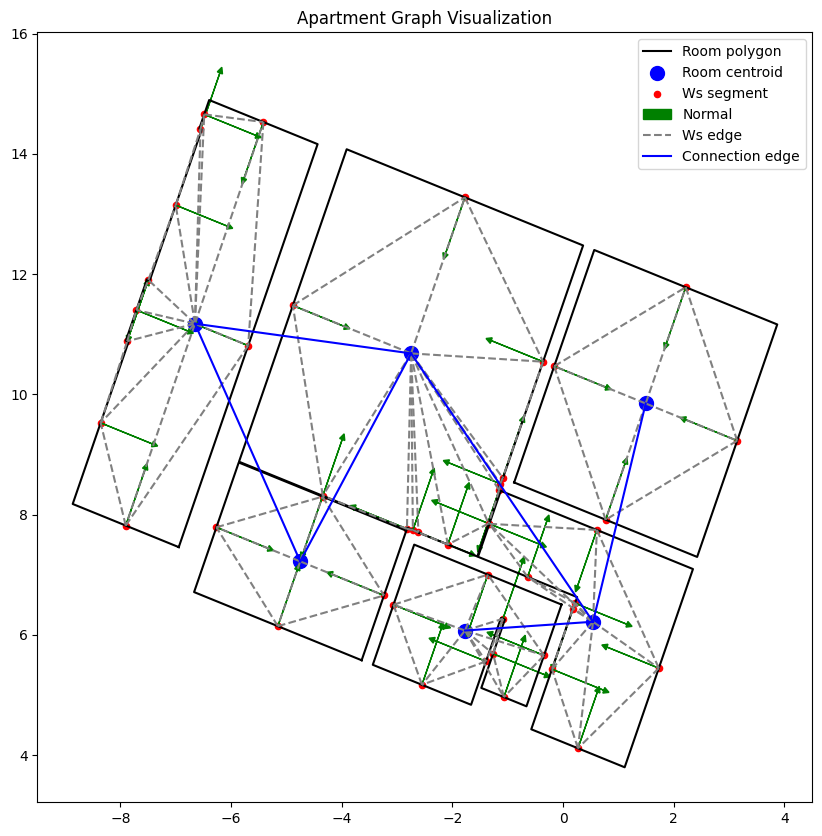

[(0, {'polygon': [(-2.6137311531828598, 7.705554853465127), (-2.8151312058771385, 7.780965416920523), (-2.828244950888429, 7.7459423536350265), (-5.856364841788982, 8.879766422340374), (-3.9107740633126804, 14.075883084940369), (0.3619886162648456, 12.476025305025914), (-1.0856109227011466, 8.609900851514645), (-1.0965930564036253, 8.614012910470773), (-1.1720036198590202, 8.412612857776494), (-1.1394989070941444, 8.400442063023647), (-1.5502398653900595, 7.303470407409023), (-2.6150051804351504, 7.70215229095945), (-2.6137311531828598, 7.705554853465127)], 'center': [-2.7468402117811843, 10.680786308129786, 1.3], 'normal': [0, 0, 1], 'type': 'room', 'category': 1, 'category_letter': 'Livingroom'}), (1, {'geom': [array([-2.61373115,  7.70555485]), array([-2.81513121,  7.78096542])], 'polygon': [(-2.6137311531828598, 7.705554853465127), (-2.8151312058771385, 7.780965416920523), (-2.8151312058771385, 7.790965416920523), (-2.6137311531828598, 7.715554853465127), (-2.6137311531828598, 7.70

In [116]:
print(original_graphs[53].graph['name'])
print(len(original_graphs[0].nodes))
print(len(original_graphs[0].edges))
# remove all node which has type != "room" or "ws"
def remove_non_room_ws(graphs):
    for graph in graphs:
        nodes_to_remove = [n for n, d in graph.nodes(data=True) if d['type'] not in ['room', 'ws']]
        graph.remove_nodes_from(nodes_to_remove)
    return graphs
original_graphs = remove_non_room_ws(original_graphs)
noise_graphs = remove_non_room_ws(noise_graphs)

# convert id to int
for i, graph in enumerate(original_graphs):
    original_graphs[i] = nx.convert_node_labels_to_integers(graph, first_label=0, ordering='default')
for i, graph in enumerate(noise_graphs):
    noise_graphs[i] = nx.convert_node_labels_to_integers(graph, first_label=0, ordering='default')


print(len(original_graphs[53].nodes))
print(len(original_graphs[53].edges))
plot_a_graph([original_graphs[53]], viz_rooms=True, viz_ws=True, viz_openings=False, viz_room_connection=True, viz_normals=False, viz_room_normals=True, viz_walls=False)
print(original_graphs[53].nodes(data=True))
print(original_graphs[53].edges(data=True))

Functions to convert DiGraphs to pyg data and viceversa, pyg data are more compatible with GNN models

In [117]:
import torch
import networkx as nx
from torch_geometric.data import Data
from typing import List, Tuple

node_type_mapping = {"room": [1, 0], "ws": [0, 1]}

def pyg_data_to_nx_digraph(data: Data, graph_list: List[nx.DiGraph], preserve_order: bool = True) -> nx.DiGraph:
    """
    Convert a PyTorch Geometric Data object back to a NetworkX DiGraph,
    restoring original node IDs using data.node_names and matching it
    with the graph in graph_list that has the same name. Optionally,
    preserve the permutation of nodes based on the preserve_order flag.
    """
    assert hasattr(data, 'node_names'), "Data object must contain 'node_names' to restore original node IDs."
    assert hasattr(data, 'name'), "Data object must contain 'name' to match with graph_list."

    # Find the matching graph in the list by name
    matching_graph = next((g for g in graph_list if g.graph.get('name') == data.name), None)
    if matching_graph is None:
        raise ValueError(f"No graph with name {data.name} found in the provided graph_list.")

    G = nx.DiGraph()

    if preserve_order: # Use the original node order from the data object
        node_ids = data.node_names
    else:
        node_ids = list(matching_graph.nodes)

    # Add nodes with attributes from the matching graph
    for i, node_id in enumerate(node_ids):
        if node_id in matching_graph.nodes:
            G.add_node(node_id, **matching_graph.nodes[node_id])

    # Add edges mapped back to original IDs
    edge_index = data.edge_index
    for u_idx, v_idx in edge_index.t().tolist():
        u = node_ids[u_idx]
        v = node_ids[v_idx]
        if matching_graph.has_edge(u, v):
            G.add_edge(u, v, **matching_graph.edges[u, v])

    # Add the graph name
    G.graph['name'] = data.name
    G.graph['node_names'] = data.node_names

    return G
    
def nx_to_pyg_data_preserve_order(graph: nx.DiGraph) -> Data:
    """
    Convert a NetworkX DiGraph to a PyTorch Geometric Data object,
    preserving the insertion order of nodes.
    """
    node_ids = list(graph.nodes())  # preserve insertion order
    id_map = {node_id: i for i, node_id in enumerate(node_ids)}

    # Build node features tensor
    x = torch.stack([
        torch.tensor(
            node_type_mapping[graph.nodes[n]['type']] +  # One-hot encoding for 'type'
            graph.nodes[n]['center'] +  # 'center' coordinates
            graph.nodes[n]['normal'] +  # 'normal' vector
            [graph.nodes[n].get('width', -1)],  # 'width', default to -1 if not present
            dtype=torch.float32
        )
        for n in node_ids
    ])

    # Remap edges using the insertion-order mapping
    edge_index = torch.tensor([
        [id_map[u], id_map[v]] for u, v in graph.edges()
    ], dtype=torch.long).t().contiguous() if graph.edges else torch.empty((2, 0), dtype=torch.long)

    # Optionally, store the original node order as a list of IDs
    data = Data(x=x, edge_index=edge_index)
    data.node_names = node_ids  # so you can always recover original labels
    data.name = graph.graph.get("name")

    return data


Generate G1,G2,GT dataset

Data(x=[52, 9], edge_index=[2, 98], node_names=[52], name='57')
G1 nodes: tensor([ 1.0000,  0.0000, -2.7468, 10.6808,  1.3000,  0.0000,  0.0000,  1.0000,
        -1.0000])
Data(x=[52, 9], edge_index=[2, 98], node_names=[52], name='57')
G2 permuted nodes: tensor([ 0.0000,  1.0000,  0.6106,  7.7452,  1.3000, -0.3507, -0.9365,  0.0000,
         3.7093])
Ground truth permutation:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])


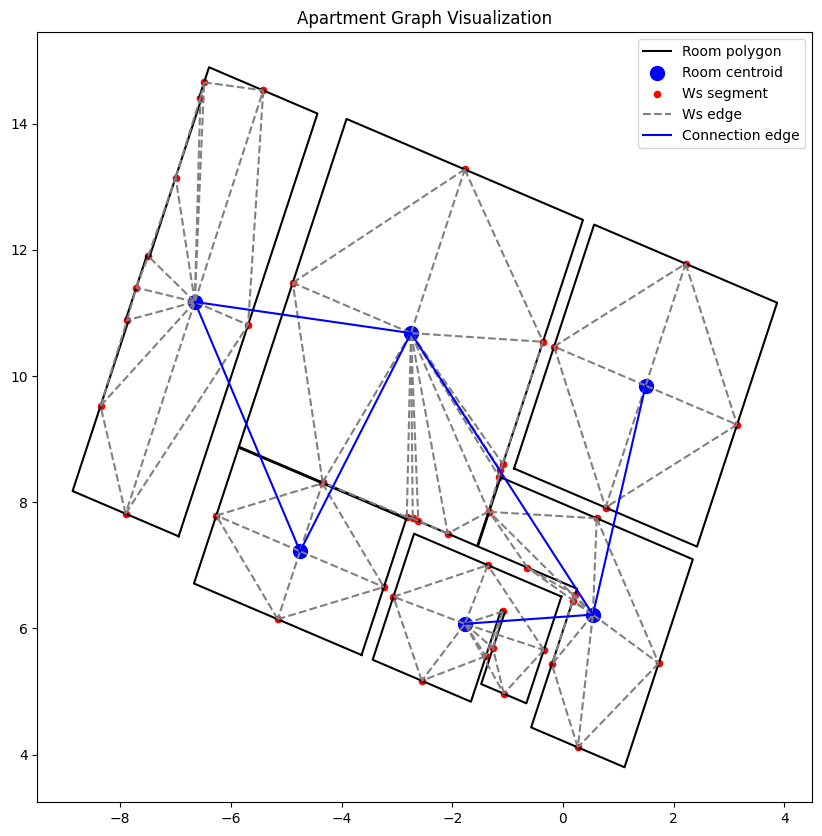

In [118]:
from sklearn.model_selection import train_test_split

def generate_matching_pairs_as_data(
    g1: nx.DiGraph,
    graph_list: List[nx.DiGraph],
    g1_idx: int,
    pairs_list: List[Tuple[Data, Data, torch.Tensor]]
) -> None:
    """
    Generate matching pairs as torch_geometric Data objects with a permutation matrix.

    Args:
        g1: Reference graph as networkx.DiGraph
        graph_list: List of all networkx.DiGraphs
        g1_idx: Index of g1 in graph_list (to skip self-pairs)
        pairs_list: List to store (Data1, Data2_permuted, P) tuples
    """

    pyg_g1 = nx_to_pyg_data_preserve_order(g1)

    for j, g2_orig in enumerate(graph_list):
        if j != g1_idx:
            continue

        assert g2_orig.number_of_nodes() == pyg_g1.num_nodes, f"Mismatch nodes in g1 ({g1_idx}) and g2 ({j})"

        num_nodes = g2_orig.number_of_nodes()
        nodes_g2 = list(sorted(g2_orig.nodes()))
        assert nodes_g2 == list(range(num_nodes)), "Nodes must be consecutively indexed"

        # Create a random permutation
        perm = torch.randperm(num_nodes)

        # Build the permutation matrix: P[i, j] = 1 if node i in G1 ↔ node j in G2_permuted
        P = torch.zeros((num_nodes, num_nodes), dtype=torch.float32)
        for i in range(num_nodes):
            P[i, perm[i]] = 1.0

        # Create permuted G2
        g2_permuted = nx.DiGraph()
        g2_permuted.graph['name'] = g2_orig.graph['name']  # Copy the name of the graph

        for new_idx in range(num_nodes):
            old_idx = perm[new_idx].item()
            g2_permuted.add_node(
                new_idx,
                type=g2_orig.nodes[old_idx]['type'],
                center=g2_orig.nodes[old_idx]['center'],
                normal=g2_orig.nodes[old_idx]['normal'],
                width=g2_orig.nodes[old_idx].get('width', -1)
            )

        for u, v, data in g2_orig.edges(data=True):
            new_u = (perm == u).nonzero(as_tuple=True)[0].item()
            new_v = (perm == v).nonzero(as_tuple=True)[0].item()
            g2_permuted.add_edge(new_u, new_v, **data)

        pyg_g2 = nx_to_pyg_data_preserve_order(g2_permuted)
        pairs_list.append((pyg_g1, pyg_g2, P.T))  # P.T so that P[i, j] = G1[i] ↔ G2[j]

# Split the data into 60% train, 20% validation, and 20% test
def split_graphs(graphs):
    train, temp = train_test_split(graphs, test_size=0.4, random_state=seed)
    val, test = train_test_split(temp, test_size=0.5, random_state=seed)
    return train, val, test

cars_train, cars_val, cars_test = split_graphs(original_graphs)

train_list = []
for i, g1 in enumerate(cars_train):
    generate_matching_pairs_as_data(g1, cars_train, i, train_list)

val_list = []
for i, g1 in enumerate(cars_val):
    generate_matching_pairs_as_data(g1, cars_val, i, val_list)

test_list = []
for i, g1 in enumerate(cars_test):
    generate_matching_pairs_as_data(g1, cars_test, i, test_list)

# Visualize the two graphs
g1_out, g2_perm, gt_perm = train_list[0]

print(g1_out)
print("G1 nodes:", g1_out.x[0])
print(g2_perm)
print("G2 permuted nodes:", g2_perm.x[0])
print("Ground truth permutation:\n", gt_perm[0])

g1_out = pyg_data_to_nx_digraph(g1_out, original_graphs)
g2_perm = pyg_data_to_nx_digraph(g2_perm, original_graphs)

plot_a_graph(
    graphs_list=[g1_out],
    viz_rooms=True,
    viz_ws=True,
    viz_openings=False,
    viz_room_connection=True,
    viz_normals=False,
    viz_room_normals=False,
    viz_walls=False
)



In [130]:
from torch.utils.data import Dataset

class GraphMatchingDataset(Dataset):
    def __init__(self, pairs):  # lista di (Data, Data, P)
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.pairs[idx]  # data1, data2, P
    
from torch_geometric.data import Batch

def collate_pyg_matching(batch):
    data1_list, data2_list, perm_list = zip(*batch)
    batch1 = Batch.from_data_list(data1_list)
    batch2 = Batch.from_data_list(data2_list)
    return batch1, batch2, perm_list

train_dataset = GraphMatchingDataset(train_list)
val_dataset = GraphMatchingDataset(val_list)
test_dataset = GraphMatchingDataset(test_list)

### Model

In [121]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class MatchingModel_2GCN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.gnn = nn.ModuleList([
            GCNConv(in_dim, hidden_dim),
            GCNConv(hidden_dim, out_dim)
        ])

    def encode(self, x, edge_index):
        for i, conv in enumerate(self.gnn):
            x = conv(x, edge_index)
            if i < len(self.gnn) - 1:
                x = F.relu(x)
        return x  # shape [num_nodes, out_dim]

    def forward(self, x1, edge_index1, x2, edge_index2):
        """
        Args:
            x1, x2: node features of graph 1 and 2 (shapes [N, in_dim])
            edge_index1, edge_index2: edge indices of graph 1 and 2 ([2, num_edges])

        Returns:
            scores: similarity matrix [N, N], where scores[i, j] = node i in G1 vs node j in G2
        """
        h1 = self.encode(x1, edge_index1)  # [N, D]
        h2 = self.encode(x2, edge_index2)  # [N, D]
        scores = torch.matmul(h1, h2.T)    # [N, N]
        return scores

### Training

In [122]:
import torch.nn.functional as F

def train_epoch(model, loader, optimizer):
    """
    Train the model for one epoch on variable-size graph pairs.

    Args:
        model: The graph matching model to train.
        loader: DataLoader providing batches of graph pairs and ground truth permutation matrices.
        optimizer: Optimizer for updating model parameters.

    Returns:
        The average loss over all batches.
    """
    model.train()
    total_loss = 0

    for batch1, batch2, P in loader:
        optimizer.zero_grad()

        x1, edge1, batch_idx1 = batch1.x, batch1.edge_index, batch1.batch
        x2, edge2, batch_idx2 = batch2.x, batch2.edge_index, batch2.batch

        h1 = model.encode(x1, edge1)
        h2 = model.encode(x2, edge2)

        loss = 0.0
        B = len(P)  # P is now a list of permutation matrices

        for i in range(B):
            h1_i = h1[batch_idx1 == i]
            h2_i = h2[batch_idx2 == i]

            sim = torch.matmul(h1_i, h2_i.T)  # [N1, N2]
            loss += F.binary_cross_entropy_with_logits(sim, P[i])

        loss /= B
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

def evaluate(model, loader):
    """
    Evaluate the model on a validation or test set.

    Args:
        model: The graph matching model to evaluate.
        loader: DataLoader providing batches of graph pairs and ground truth permutation matrices.

    Returns:
        The accuracy of the model.
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch1, batch2, P in loader:
            x1, edge1, batch_idx1 = batch1.x, batch1.edge_index, batch1.batch
            x2, edge2, batch_idx2 = batch2.x, batch2.edge_index, batch2.batch

            h1 = model.encode(x1, edge1)
            h2 = model.encode(x2, edge2)

            B = len(P)

            for i in range(B):
                h1_i = h1[batch_idx1 == i]
                h2_i = h2[batch_idx2 == i]

                sim = torch.matmul(h1_i, h2_i.T)

                pred = sim.argmax(dim=1)          # predicted indices
                target = P[i].argmax(dim=1)       # ground truth indices

                correct += (pred == target).sum().item()
                total += h1_i.size(0)

    return correct / total if total > 0 else 0.0


In [131]:
from torch.utils.data import DataLoader

# Define hyperparameters
in_dim = 9  # Dimension of node features
hidden_dim = 64  # Hidden dimension for GNN
out_dim = 32  # Output dimension for GNN
num_epochs = 100
learning_rate = 0.001
batch_size = 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_pyg_matching, generator=g)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)

model = MatchingModel_2GCN(in_dim=in_dim, hidden_dim=hidden_dim, out_dim=out_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    loss = train_epoch(model, train_loader, optimizer)
    acc = evaluate(model, val_loader)
    print(f"[Epoch {epoch}] Loss: {loss:.4f} | Val Acc: {acc:.4f}")


[Epoch 0] Loss: 40.1478 | Val Acc: 0.0241
[Epoch 1] Loss: 24.4487 | Val Acc: 0.0261
[Epoch 2] Loss: 15.0108 | Val Acc: 0.0311
[Epoch 3] Loss: 9.5773 | Val Acc: 0.0361
[Epoch 4] Loss: 6.3518 | Val Acc: 0.0432
[Epoch 5] Loss: 4.4159 | Val Acc: 0.0492
[Epoch 6] Loss: 3.1966 | Val Acc: 0.0602
[Epoch 7] Loss: 2.4663 | Val Acc: 0.0673
[Epoch 8] Loss: 1.9972 | Val Acc: 0.0743
[Epoch 9] Loss: 1.6771 | Val Acc: 0.0763
[Epoch 10] Loss: 1.4749 | Val Acc: 0.0823
[Epoch 11] Loss: 1.3234 | Val Acc: 0.0873
[Epoch 12] Loss: 1.2253 | Val Acc: 0.0884
[Epoch 13] Loss: 1.1471 | Val Acc: 0.0924
[Epoch 14] Loss: 1.0848 | Val Acc: 0.0924
[Epoch 15] Loss: 1.0350 | Val Acc: 0.0934
[Epoch 16] Loss: 0.9926 | Val Acc: 0.0934
[Epoch 17] Loss: 0.9610 | Val Acc: 0.1004
[Epoch 18] Loss: 0.9328 | Val Acc: 0.1024
[Epoch 19] Loss: 0.9102 | Val Acc: 0.1034
[Epoch 20] Loss: 0.8898 | Val Acc: 0.1074
[Epoch 21] Loss: 0.8724 | Val Acc: 0.1094
[Epoch 22] Loss: 0.8568 | Val Acc: 0.1114
[Epoch 23] Loss: 0.8447 | Val Acc: 0.1145

In [128]:
evaluate(model, test_loader)
print(f"Test Acc: {acc:.4f}")

def predict_matching_matrix(model, data1, data2, hard=True):
    model.eval()
    with torch.no_grad():
        h1 = model.encode(data1.x, data1.edge_index)
        h2 = model.encode(data2.x, data2.edge_index)
        sim = torch.matmul(h1, h2.T)  # [N1, N2]

        if hard:
            pred = sim.argmax(dim=1)
            P_pred = torch.zeros_like(sim)
            P_pred[torch.arange(sim.size(0)), pred] = 1
            return P_pred
        else:
            return F.softmax(sim, dim=1)

# use the model to predict the matching on a test graph
g1_out, g2_perm, gt_perm = test_list[0]

P_pred = predict_matching_matrix(model, g1_out, g2_perm, hard=True)

print(P_pred)  # matrice binaria di permutazione predetta


Test Acc: 0.2219
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

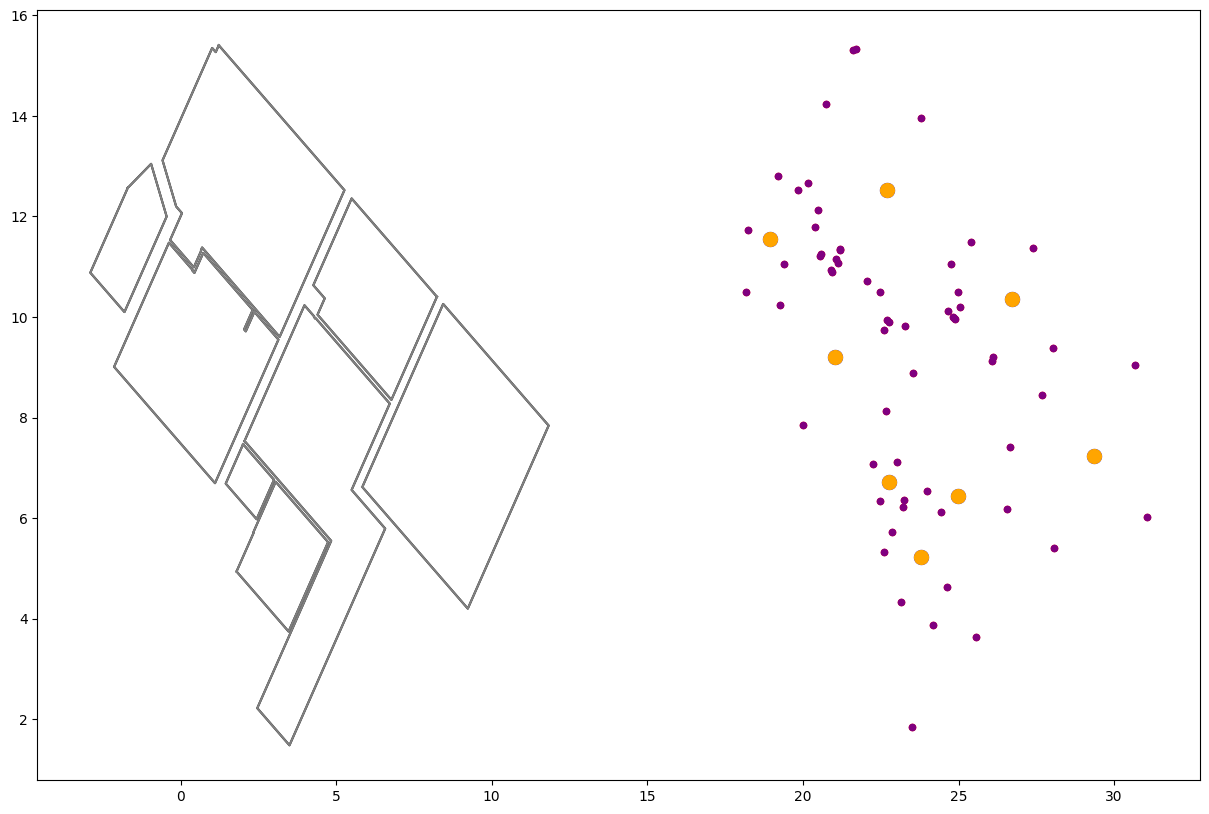

In [126]:
def plot_two_graphs_with_matching(graphs_list, gt_perm, pred_perm, viz_rooms=True, viz_ws=True, viz_room_connection=True, viz_normals=False, viz_room_normals=False):
    """
    Visualizes two graphs side by side with matching edges.

    Parameters:
    graphs_list (list of networkx.Graph): List containing two graphs to visualize.
    gt_perm (torch.Tensor): Ground truth permutation matrix.
    pred_perm (torch.Tensor): Predicted permutation matrix.
    viz_normals (bool): If True, plots wall segment normals.
    viz_rooms (bool): If True, displays room polygons.
    viz_ws (bool): If True, displays wall segments.
    viz_room_connection (bool): If True, displays edges connecting rooms.
    """
    assert len(graphs_list) == 2, "graphs_list must contain exactly two graphs."
    g1, g2 = graphs_list

    # Calculate the translation value for the second graph
    max_x_g1 = max(data['center'][0] for _, data in g1.nodes(data=True))
    translation_x = max_x_g1 + 10  # Add some padding for better visualization

    # Translate the second graph
    for _, data in g2.nodes(data=True):
        data['center'][0] += translation_x

    _, ax = plt.subplots(1, 1, figsize=(15, 10))
    legend_added = False  # Flag to ensure the legend is added only once

    # Visualize the first graph
    if viz_rooms:
        room_nodes_g1 = [n for n, d in g1.nodes(data=True) if d['type'] == 'room']
        for idx, room_node in enumerate(room_nodes_g1):
            room_data = g1.nodes[room_node]
            room_polygon = Polygon(room_data['polygon'])
            x, y = room_polygon.exterior.xy
            ax.plot(x, y, color='black', label='Room polygon (G1)' if not legend_added and idx == 0 else "")
            ax.scatter(room_data['center'][0], room_data['center'][1], color='blue', s=100, label='Room centroid (G1)' if not legend_added and idx == 0 else "")

    if viz_ws:
        ws_nodes_g1 = [n for n, d in g1.nodes(data=True) if d['type'] == 'ws']
        for idx, wn in enumerate(ws_nodes_g1):
            ws_data = g1.nodes[wn]
            ax.scatter(ws_data['center'][0], ws_data['center'][1], color='red', s=20, label='Ws segment (G1)' if not legend_added and idx == 0 else "")

    # Visualize the second graph
    if viz_rooms:
        room_nodes_g2 = [n for n, d in g2.nodes(data=True) if d['type'] == 'room']
        for idx, room_node in enumerate(room_nodes_g2):
            room_data = g2.nodes[room_node]
            room_polygon = Polygon(room_data['polygon'])
            x, y = room_polygon.exterior.xy
            ax.plot(x, y, color='gray', label='Room polygon (G2)' if not legend_added and idx == 0 else "")
            ax.scatter(room_data['center'][0], room_data['center'][1], color='orange', s=100, label='Room centroid (G2)' if not legend_added and idx == 0 else "")

    if viz_ws:
        ws_nodes_g2 = [n for n, d in g2.nodes(data=True) if d['type'] == 'ws']
        for idx, wn in enumerate(ws_nodes_g2):
            ws_data = g2.nodes[wn]
            ax.scatter(ws_data['center'][0], ws_data['center'][1], color='purple', s=20, label='Ws segment (G2)' if not legend_added and idx == 0 else "")

    # Draw matching edges
    for i in range(gt_perm.size(0)):
        for j in range(gt_perm.size(1)):
            if gt_perm[i, j] == 1:  # Ground truth match
                color = 'green' if pred_perm[i, j] == 1 else 'red'
                start = g1.nodes[i]['center']
                end = g2.nodes[j]['center']
                ax.plot([start[0], end[0]], [start[1], end[1]], color=color, linestyle='-', alpha=0.7)

    legend_added = True
    plt.title("Graph Matching Visualization")
    plt.legend()
    plt.show()



g1_out = pyg_data_to_nx_digraph(g1_out, original_graphs, preserve_order=False)
g2_perm = pyg_data_to_nx_digraph(g2_perm, original_graphs, preserve_order=False)
plot_two_graphs_with_matching([g1_out, g2_perm], gt_perm[0], P_pred[0], viz_rooms=True, viz_ws=True, viz_room_connection=True, viz_normals=False, viz_room_normals=False)

In [132]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

def plot_two_graphs_with_matching(graphs_list, gt_perm, pred_perm,
                                  viz_rooms=True, viz_ws=True,
                                  viz_room_connection=True,
                                  viz_normals=False, viz_room_normals=False):
    """
    Visualizes two graphs side by side with matching edges (green = correct, red = wrong).

    Args:
        graphs_list (list): [G1, G2], both as networkx.DiGraph.
        gt_perm (Tensor): Ground truth permutation matrix (N1 x N2).
        pred_perm (Tensor): Predicted permutation matrix (N1 x N2).
    """
    assert len(graphs_list) == 2, "graphs_list must contain exactly two graphs."
    g1, g2 = graphs_list

    # Compute horizontal translation for G2
    max_x_g1 = max(data['center'][0] for _, data in g1.nodes(data=True))
    min_x_g2 = min(data['center'][0] for _, data in g2.nodes(data=True))
    translation_x = (max_x_g1 - min_x_g2) + 5.0  # add padding

    # Translate G2
    for _, data in g2.nodes(data=True):
        data['center'][0] += translation_x
        if 'polygon' in data:
            poly = Polygon(data['polygon'])
            translated_poly = Polygon([(x + translation_x, y) for x, y in poly.exterior.coords])
            data['polygon'] = translated_poly

    fig, ax = plt.subplots(figsize=(14, 10))
    legend_added = set()

    def plot_graph(g, is_g1):
        color_room = 'blue' if is_g1 else 'orange'
        color_ws = 'red' if is_g1 else 'purple'
        prefix = "(G1)" if is_g1 else "(G2)"

        if viz_rooms:
            for i, (n, d) in enumerate(g.nodes(data=True)):
                if d['type'] == 'room':
                    if isinstance(d['polygon'], Polygon):
                        poly = d['polygon']
                    else:
                        poly = Polygon(d['polygon'])
                    x, y = poly.exterior.xy
                    ax.plot(x, y, color='black', linewidth=1, alpha=0.6,
                            label=f"Room polygon {prefix}" if "room-poly-"+prefix not in legend_added else "")
                    ax.scatter(d['center'][0], d['center'][1], color=color_room, s=80,
                               label=f"Centroid {prefix}" if "room-pt-"+prefix not in legend_added else "")
                    legend_added.add("room-poly-"+prefix)
                    legend_added.add("room-pt-"+prefix)

        if viz_ws:
            for i, (n, d) in enumerate(g.nodes(data=True)):
                if d['type'] == 'ws':
                    ax.scatter(d['center'][0], d['center'][1], color=color_ws, s=20,
                               label=f"WS {prefix}" if "ws-"+prefix not in legend_added else "")
                    legend_added.add("ws-"+prefix)

    # Plot both graphs
    plot_graph(g1, is_g1=True)
    plot_graph(g2, is_g1=False)

    # Draw matching: green if pred == gt, red otherwise
    for i in range(gt_perm.shape[0]):
        for j in range(gt_perm.shape[1]):
            if gt_perm[i, j] == 1:
                color = 'green' if pred_perm[i, j] == 1 else 'red'
                pt1 = g1.nodes[i]['center']
                pt2 = g2.nodes[j]['center']
                ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]],
                        color=color, linestyle='-', alpha=0.6,
                        label='Correct match' if color == 'green' and 'correct' not in legend_added else (
                              'Wrong match' if color == 'red' and 'wrong' not in legend_added else None))
                if color == 'green': legend_added.add('correct')
                if color == 'red': legend_added.add('wrong')

    ax.set_title("Graph Matching: Green = Correct, Red = Wrong")
    ax.axis('equal')
    ax.legend()
    plt.tight_layout()
    plt.show()




In [136]:
g1_out = pyg_data_to_nx_digraph(g1_out, original_graphs, preserve_order=False)
g2_perm = pyg_data_to_nx_digraph(g2_perm, original_graphs, preserve_order=False)
plot_two_graphs_with_matching(
    [g1_out, g2_perm],
    gt_perm=gt_perm,
    pred_perm=P_pred,
    viz_rooms=True,
    viz_ws=True
)


AssertionError: Data object must contain 'node_names' to restore original node IDs.